In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.env_utils import *
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Expert
max_steps = 100

# Training
num_generations = 5
gamma = 0.999

# Policy
lr_policy = 5e-4
num_perturbations = 32
sigma = 0.07
deterministic=True

# Discriminator
dis_balance_factor = 5
noise = 0.002
lr_disc = 1e-4
lambda_gp = 5

performance_eval = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def sliding_window(tensor, window_size=10):
    sequences = []
    for start in range(0, tensor.size(0) - window_size + 1):
        end = start + window_size
        sequences.append(tensor[start:end])
    return torch.stack(sequences)

In [4]:
%matplotlib tk
_, exp_prey_sequence, couzin_metrics, init_pool = run_couzin_simulation(visualization="off", max_steps=max_steps, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         dt = 0.5, # step_size
                                         alpha=0.01, # social behavior - attack only
                                         theta_dot_max=0.5, theta_dot_max_shark=0.5,
                                         number_of_sharks=0, n=32)

#_, exp_prey_sequence, _, init_pool = run_circular_simulation(visualization="off", max_steps=100)

exp_prey_sequence = exp_prey_sequence.to(device)
init_pool = init_pool.to(device)

exp_prey_tensor = sliding_window(exp_prey_sequence, window_size=10)

print("Prey Tensor Shape:", exp_prey_tensor.shape)


Prey Tensor Shape: torch.Size([91, 10, 32, 31, 5])


In [5]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=10, optimizer=prey_optimizer, role="prey")

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

epoch 010: loss=23.027592 sim=0.0460 std=1.3172 cov=0.4242 std_mean=0.341
Prey Encoder trained & frozen.



In [6]:
%matplotlib inline
prey_policy = ModularPolicy(features=5).to(device)
pretrain_policy(prey_policy, "prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=5, lr=1e-3, deterministic=deterministic, device=device)
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy pretrained.\n")

IndexError: index 5 is out of bounds for dimension 2 with size 5

In [ ]:
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

In [ ]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to("cuda")
    
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=prey_policy, 
                                                          pred_policy=None, 
                                                          n_prey=32, n_pred=1, max_steps=100,
                                                          init_pool=init_pool)

    for i in range(dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        disc_metrics_list.append((dis_metric_prey))
        
    # Predator Policy Update
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    # Prey Policy Update
    pin_prey_metrics = optimize_es(pred_policy, prey_policy, "prey", "pairwise", "mean", 
                                   prey_discriminator, lr=lr_policy, sigma=sigma, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, device="cuda")
    
    an_prey_metrics  = optimize_es(pred_policy, prey_policy, "prey", "attention", "mean", 
                                   prey_discriminator, lr=lr_policy, sigma=sigma,
                                   num_perturbations=num_perturbations, init_pos=init_pos, device="cuda")
    ema_prey.update()

    policy_metrics_list.append((pin_prey_metrics, an_prey_metrics))
    
    lr_policy *= gamma
    sigma *= gamma

    current_prey_state = ema_prey.ema_model.state_dict()

    if gen % performance_eval == 0:
        metrics = calculate_metrics(pred_policy, prey_policy, init_pool, 
                      pred_encoder, prey_encoder, exp_pred_tensor, exp_prey_tensor,
                      pred_mmd_loss, prey_mmd_loss, sinkhorn_loss, device="cuda")
        metrics_list.append(metrics)

        best_prey = metrics["mmd_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
        
    if metrics["mmd_prey_mean"] < best_prey:
        best_prey = metrics["mmd_prey_mean"]
        print(f"New best Prey MMD: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.4f} ± {metrics['sinkhorn_prey_std']:.4f}")

prey_policy.load_state_dict(best_prey_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_min': -100724.117188, 'diff_max': -0.015591, 'diff_mean': -3228.108154, 'diff_std': 17515.488281, 'delta_norm': 0.025913, 'clip_ratio': 1.0, 'delta_raw_norm': 0.025913, 'max_delta_norm': 0.071841}
[PREY] AN Network:    {'diff_min': -346125536.0, 'diff_max': -0.015452, 'diff_mean': -27388522.0, 'diff_std': 85967312.0, 'delta_norm': 0.025976, 'clip_ratio': 1.0, 'delta_raw_norm': 0.025976, 'max_delta_norm': 0.073067}
[PREY] Discriminator: {'dis_loss': 0.0007, 'dis_loss_gp': 4.7334, 'grad_penalty': 0.9465, 'expert_score_mean': -0.1553, 'policy_score_mean': -0.1546}
[PREY] Score Diff: 0.0007000000000000062
[PREY] MMD: 0.5083 ± 0.1195 | Sinkhorn: 84414450892.8002 ± 369807745398.4608

Generation 2
[PREY] PIN Network:   {'diff_min': -8.628084896704758e+18, 'diff_max': -0.02528, 'diff_mean': -2.6973557696023757e+17, 'diff_std': 1.501204044771754e+18, 'delta_norm': 0.026294, 'clip_ratio': 1.0, 'delta_raw_norm': 0.026294, 'max_delta_norm': 0.071842}
[PREY

c:\Users\janni\OneDrive\Dokumente\Privat\Bildung\M. Sc. Social and Economic Data Science\4. Semester\Master Thesis\Code\notebooks - gail_testing\utils\sim_utils.py:81: RuntimeWarning: invalid value encountered in subtract
  dx = xs_scaled[None, :] - xs_scaled[:, None]
c:\Users\janni\OneDrive\Dokumente\Privat\Bildung\M. Sc. Social and Economic Data Science\4. Semester\Master Thesis\Code\notebooks - gail_testing\utils\sim_utils.py:82: RuntimeWarning: invalid value encountered in subtract
  dy = ys_scaled[None, :] - ys_scaled[:, None]


ValueError: Expected parameter loc (Tensor of shape (32, 31, 1)) of distribution Normal(loc: torch.Size([32, 31, 1]), scale: torch.Size([32, 31, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]])

In [ ]:
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

save_path = run_dir / "prey_only_policy.pth"
torch.save(prey_policy.state_dict(), save_path)

In [ ]:
def get_expert_values(exp_prey_tensor,
                      prey_mmd_loss,
                      prey_encoder,
                      sinkhorn_loss, device):
    
    prey_mmd_list = []
    prey_sinkhorn_list = []

    exp_prey_tensor = exp_prey_tensor.to(device)

    for i in tqdm(range(1000)):
        # MMD
        expert_prey_batch1 = sample_data(exp_prey_tensor, consecutive_frames=10, batch_size=10)
        expert_prey_batch2 = sample_data(exp_prey_tensor, consecutive_frames=10, batch_size=10)

        prey_mmd = prey_mmd_loss(expert_prey_batch1, expert_prey_batch2).item()
        prey_mmd_list.append(prey_mmd)

        # Sinkhorn
        _, trans_exp_prey = prey_encoder(expert_prey_batch1[...,:4])
        _, trans_gen_prey = prey_encoder(expert_prey_batch2[...,:4])

        batch, frames, agents, dim = trans_exp_prey.shape
        prey_x = trans_exp_prey.reshape(batch * frames, agents, dim)
        prey_y = trans_gen_prey.reshape(batch * frames, agents, dim)

        sinkhorn_prey = sinkhorn_loss(prey_x, prey_y)
        prey_sinkhorn_list.append(sinkhorn_prey.mean().item())

    print(f"\nExpert Prey MMD: {np.mean(prey_mmd_list)} ± {np.std(prey_mmd_list)}")
    print(f"Expert Prey Sinkhorn: {np.mean(prey_sinkhorn_list)} ± {np.std(prey_sinkhorn_list)}\n")

    mmd_means = (np.mean(prey_mmd_list),)
    mmd_stds = (np.std(prey_mmd_list),)

    sinkhorn_means = (np.mean(prey_sinkhorn_list),)
    sinkhorn_stds = (np.std(prey_sinkhorn_list),)

    return mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds


mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(
    exp_tensor,
    mmd_loss,
    encoder,
    sinkhorn_loss, device
)

100%|██████████| 1000/1000 [00:32<00:00, 30.87it/s]


Expert Prey MMD: 0.04224584460258484 ± 0.03915364842786694
Expert Prey Sinkhorn: 1.0412301716314687e-05 ± 2.25518939666941e-06



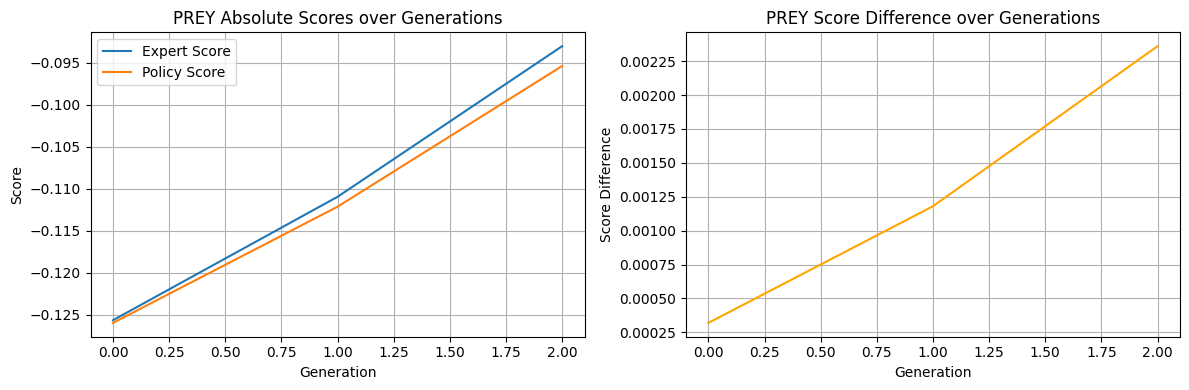

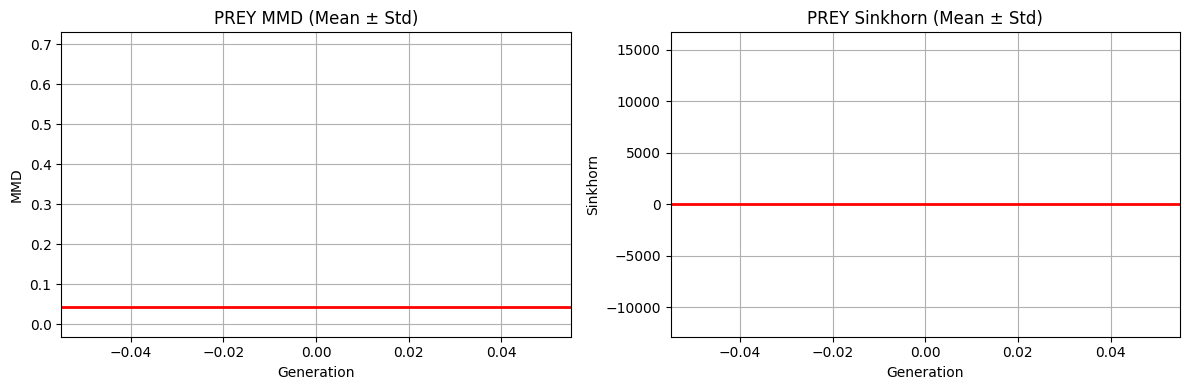

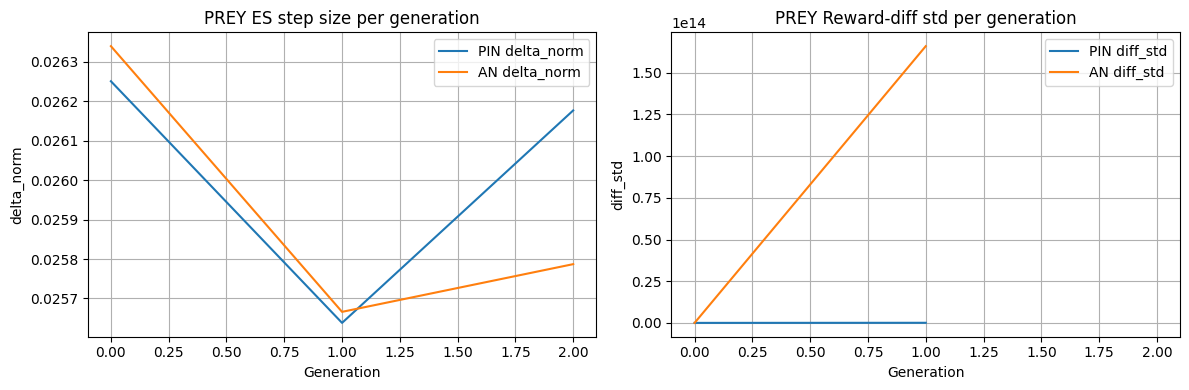

In [ ]:
def plot_train_metrics(disc_metrics, role="prey", save_dir=None):
    disc_df = pd.DataFrame(disc_metrics)
    disc_df["gen"] = (disc_df.index // dis_balance_factor) + 1
    disc_mean = disc_df.groupby("gen").mean(numeric_only=True).sort_index()

    gens = np.arange(len(disc_mean))

    score_diffs = (disc_mean["expert_score_mean"] - disc_mean["policy_score_mean"]).abs().to_numpy()
    abs_scores = disc_mean[["expert_score_mean", "policy_score_mean"]].to_numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Left: Absolute scores
    axes[0].plot(gens, abs_scores[:, 0], label="Expert Score")
    axes[0].plot(gens, abs_scores[:, 1], label="Policy Score")
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("Score")
    axes[0].set_title(f"{role.upper()} Absolute Scores over Generations")
    axes[0].legend()
    axes[0].grid(True)

    # Right: Score diffs
    axes[1].plot(gens, score_diffs, color="orange")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Score Difference")
    axes[1].set_title(f"{role.upper()} Score Difference over Generations")
    axes[1].grid(True)

    plt.tight_layout()

    plot_path = save_dir / f"disc_{role}_metrics.png"
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()


def plot_eval_metrics(metrics_list, 
                      mmd_means=None, sinkhorn_means=None, 
                      mmd_stds=None, sinkhorn_stds=None,
                      role="prey", save_dir=None):
    
    xs = np.arange(len(metrics_list))

    # prey-only
    mmd_mean = np.array([m["mmd_prey_mean"] for m in metrics_list], dtype=float)
    mmd_std  = np.array([m["mmd_prey_std"]  for m in metrics_list], dtype=float)
    sk_mean  = np.array([m["sinkhorn_prey_mean"] for m in metrics_list], dtype=float)
    sk_std   = np.array([m["sinkhorn_prey_std"]  for m in metrics_list], dtype=float)

    exp_mmd_mean = mmd_means[0]
    exp_mmd_std = mmd_stds[0]
    exp_sinkhorn_mean = sinkhorn_means[0]
    exp_sinkhorn_std = sinkhorn_stds[0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axes[0].plot(xs, mmd_mean, label=f"{role.upper()} MMD")
    axes[0].fill_between(xs, mmd_mean - mmd_std, mmd_mean + mmd_std, alpha=0.2)
    axes[0].axhline(exp_mmd_mean, color="red", linewidth=2, label="Expert MMD Mean ± Std")
    axes[0].fill_between(xs, exp_mmd_mean - exp_mmd_std, exp_mmd_mean + exp_mmd_std, alpha=0.2)
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("MMD")
    axes[0].set_title(f"{role.upper()} MMD (Mean ± Std)")
    axes[0].grid(True)

    axes[1].plot(xs, sk_mean, label=f"{role.upper()} Sinkhorn")
    axes[1].fill_between(xs, sk_mean - sk_std, sk_mean + sk_std, alpha=0.2)
    axes[1].axhline(exp_sinkhorn_mean, color="red", linewidth=2, label="Expert Sinkhorn Mean ± Std")
    axes[1].fill_between(xs, exp_sinkhorn_mean - exp_sinkhorn_std, exp_sinkhorn_mean + exp_sinkhorn_std, alpha=0.2)
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("Sinkhorn")
    axes[1].set_title(f"{role.upper()} Sinkhorn (Mean ± Std)")
    axes[1].grid(True)

    plt.tight_layout()

    filename = f"eval_{role}_metrics.png"
    plot_path = save_dir / filename
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()



def plot_es_metrics(policy_metrics, role="prey", save_dir=None):
    gens = np.arange(len(policy_metrics))

    pin_delta_norm = np.array([pm[0].get("delta_norm", np.nan) for pm in policy_metrics], dtype=float)
    an_delta_norm  = np.array([pm[1].get("delta_norm", np.nan) for pm in policy_metrics], dtype=float)

    pin_diff_std = np.array([pm[0].get("diff_std", np.nan) for pm in policy_metrics], dtype=float)
    an_diff_std  = np.array([pm[1].get("diff_std", np.nan) for pm in policy_metrics], dtype=float)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    axes[0].plot(gens, pin_delta_norm, label="PIN delta_norm")
    axes[0].plot(gens, an_delta_norm, label="AN delta_norm")
    axes[0].set_xlabel("Generation")
    axes[0].set_ylabel("delta_norm")
    axes[0].set_title(f"{role.upper()} ES step size per generation")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(gens, pin_diff_std, label="PIN diff_std")
    axes[1].plot(gens, an_diff_std, label="AN diff_std")
    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("diff_std")
    axes[1].set_title(f"{role.upper()} Reward-diff std per generation")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()

    plot_path = save_dir / f"es_{role}_policy_metrics.png"
    fig.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()

plot_train_metrics(disc_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", mmd_means=mmd_means, mmd_stds=mmd_stds, sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)

In [ ]:
%matplotlib tk
_, gen_prey_tensor = run_env_simulation(visualization='on', prey_policy=prey_policy, pred_policy=None,
        n_prey=32, n_pred=0, max_steps=200,
        pred_speed=5, prey_speed=5,
        area_width=50, area_height=50)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (992x4 and 5x100)

In [ ]:
%matplotlib tk
_, exp_tensor, _ = run_couzin_simulation(visualization="on", max_steps=100, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=0, n=32)

ValueError: too many values to unpack (expected 3)